In [26]:
! pip install langchain langchain-community langchain-openai



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [27]:
! pip install python-dotenv



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
! pip install sentence-transformers faiss-cpu langchain huggingface-hub



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
! pip install langchain langchain-experimental



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
! pip install tabulate
! pip install tabulate matplotlib seaborn numpy



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [31]:
import os
import requests
import pandas as pd
from dotenv import load_dotenv

from langchain.chat_models import ChatOpenAI
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent

# .env 読み込み
load_dotenv()

# =========================
# 🔐 Metabase 認証・データ取得
# =========================

login_url = "https://metabase.tr-com.net/api/session"
username = os.getenv("MB_USERNAME", "").strip()
password = os.getenv("MB_PASSWORD", "").strip()

if not username or not password:
    raise ValueError("❌ MB_USERNAME または MB_PASSWORD が設定されていません")

print(f"ログイン試行中 → username: '{username}'")

response = requests.post(login_url, json={"username": username, "password": password})
if response.status_code == 200:
    session_id = response.json().get("id")
    print("✅ ログイン成功")
else:
    raise Exception(f"❌ ログイン失敗: {response.status_code}, {response.text}")
# API URL
url = "https://metabase.tr-com.net/api/card/2040/query/json"

# Headers
headers = {
    "Content-Type": "application/json",
    "X-Metabase-Session": session_id
}

# Payload
payload = {
    "parameters": [
        {
            "type": "category",
            "target": ["variable", ["template-tag", "sensorid"]],
            "value": "VC00418B"
        }
    ]
}


ログイン試行中 → username: 'y-nitta@torishima.co.jp'
✅ ログイン成功


In [32]:

# Make the request
response = requests.post(url, headers=headers, json=payload)
if response.status_code == 200:
    try:
        data = response.json()
        df = pd.DataFrame(data)
        if df.empty:
            raise ValueError("❌ 取得したデータが空です。Metabaseを確認してください。")
        print("✅ データ取得成功")
        print(df)
    except Exception as e:
        raise Exception(f"❌ データ取得・DataFrame変換失敗: {e}")
else:
    raise Exception(f"❌ データ取得失敗: {response.status_code}, {response.text}")


✅ データ取得成功
    sensorid                   UserId            TimeStamp  \
0   VC00418B  y-nitta@torishima.co.jp  2025-04-18T04:53:15   
1   VC00418B  y-nitta@torishima.co.jp  2025-04-18T04:57:14   
2   VC00418B  y-nitta@torishima.co.jp  2025-04-18T05:01:19   
3   VC00418B  y-nitta@torishima.co.jp  2025-04-18T05:08:50   
4   VC00418B  y-nitta@torishima.co.jp  2025-04-18T05:12:40   
5   VC00418B  y-nitta@torishima.co.jp  2025-04-18T05:17:15   
6   VC00418B  y-nitta@torishima.co.jp  2025-04-18T05:21:24   
7   VC00418B  y-nitta@torishima.co.jp  2025-04-18T05:29:30   
8   VC00418B  y-nitta@torishima.co.jp  2025-04-18T05:30:01   
9   VC00418B  y-nitta@torishima.co.jp  2025-04-18T05:35:25   
10  VC00418B  y-nitta@torishima.co.jp  2025-04-18T05:44:06   

             recordDate     VRMSX     VRMSXAcc  Temperature  
0   2025-04-18T04:53:15  0.025984  1412.598425        35.11  
1   2025-04-18T04:57:14  0.029134  1412.598425        35.11  
2   2025-04-18T05:01:19  0.019291  1411.811024        35.73

In [33]:

# =========================
# 🤖 Pandas Agent 設定
# =========================

llm = ChatOpenAI(
    model="gpt-4o-mini",
    openai_api_key=os.getenv("OPENAI_API_KEY"),
    temperature=0.2,
    max_tokens=500,
)

agent = create_pandas_dataframe_agent(
    llm,
    df,
    verbose=True,
    allow_dangerous_code=True  
)

# =========================
# 💬 質問関数と会話ループ
# =========================

def ask_question(question: str):
    try:
        response = agent.run(question)
        print(f"👤 {question}")
        print(f"🤖 {response}\n")
    except Exception as e:
        print(f"❌ エラー: {e}")

def talk():
    print("🔁 DataFrame QAエージェント開始（'exit' または '終了' で終了）")
    while True:
        try:
            user_input = input("👤 ")
            if user_input.lower() in ["exit", "終了", "quit"]:
                print("🛑 終了します")
                break
            response = agent.run(user_input)
            print(f"🤖 {response}\n")
        except KeyboardInterrupt:
            print("\n🛑 中断されました。会話を終了します")
            break

# =========================
# ✅ 使用例
# =========================

# ask_question("3列目の最頻値は？")
# talk()


In [34]:
ask_question("何ができる？")




> Entering new AgentExecutor chain...
Thought: この質問は、データフレーム `df` に対してどのような操作や分析が可能かを尋ねています。具体的には、データの要約、フィルタリング、集計、可視化などが考えられます。まずは、データフレームの基本的な情報を確認して、どのような操作が可能かを考えます。
Action: python_repl_ast
Action Input: df.info()<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sensorid     11 non-null     object 
 1   UserId       11 non-null     object 
 2   TimeStamp    11 non-null     object 
 3   recordDate   11 non-null     object 
 4   VRMSX        11 non-null     float64
 5   VRMSXAcc     11 non-null     float64
 6   Temperature  11 non-null     float64
dtypes: float64(3), object(4)
memory usage: 748.0+ bytes
データフレーム `df` には、11行と7列のデータが含まれています。各列のデータ型は以下の通りです：

- `sensorid`: オブジェクト型（文字列）
- `UserId`: オブジェクト型（文字列）
- `TimeStamp`: オブジェクト型（文字列）
- `recordDate`: オブジェクト型（文字列）
- `VRMSX`: 浮動小数点型
- `VRMSXAcc`: 浮動小数点型
- `Temperature`: 浮動小数点型

この情報から、以下のような操作が可

In [35]:
ask_question("VRMSXAccのデータをまとめて？")




> Entering new AgentExecutor chain...
Thought: I need to summarize the `VRMSXAcc` column in the dataframe `df`. Common summary statistics include count, mean, standard deviation, minimum, maximum, and quartiles. I will calculate these statistics using the `describe()` method in pandas.

Action: python_repl_ast  
Action Input: df['VRMSXAcc'].describe()  count      11.000000
mean     1450.894775
std        35.964558
min      1411.811024
25%      1416.535433
50%      1454.330709
75%      1474.803150
max      1522.047244
Name: VRMSXAcc, dtype: float64I now know the final answer. The summary statistics for the `VRMSXAcc` column are as follows:

- Count: 11
- Mean: 1450.89
- Standard Deviation: 35.96
- Minimum: 1411.81
- 25th Percentile: 1416.54
- Median (50th Percentile): 1454.33
- 75th Percentile: 1474.80
- Maximum: 1522.05

Final Answer: The summary statistics for the `VRMSXAcc` column are: count = 11, mean = 1450.89, std = 35.96, min = 1411.81, 25% = 1416.54, 50% = 1454.33, 75% = 1474.



> Entering new AgentExecutor chain...
Thought: 特徴的なデータを探すためには、データフレームの統計情報や分布を確認することが重要です。特に、数値データの分布や異常値を探すために、基本的な統計量を計算したり、ヒストグラムを作成したりすることが考えられます。まずは、数値列の基本統計量を確認してみます。

Action: python_repl_ast
Action Input: df.describe()           VRMSX     VRMSXAcc  Temperature
count  11.000000    11.000000    11.000000
mean    0.024517  1450.894775    35.617273
std     0.005070    35.964558     0.266274
min     0.018898  1411.811024    35.110000
25%     0.020669  1416.535433    35.580000
50%     0.021654  1454.330709    35.730000
75%     0.028740  1474.803150    35.780000
max     0.033071  1522.047244    35.830000基本統計量を確認した結果、数値データの分布がわかりました。特に、`VRMSX`の最大値は0.033071、最小値は0.018898であり、`VRMSXAcc`の最大値は1522.047244、最小値は1411.811024です。また、`Temperature`の範囲は35.11から35.83です。これらの情報から、特に`VRMSXAcc`の値が大きく変動していることがわかります。次に、異常値や特徴的なデータを視覚的に確認するために、ヒストグラムを作成してみます。

Action: python_repl_ast
Action Input: df[['VRMSX', 'VRMSXAcc', 'Temperature']].hist(bins=10, figsize=(10, 5)) [[<Axes: title={'center': 'VRMSX'}> <Axes:

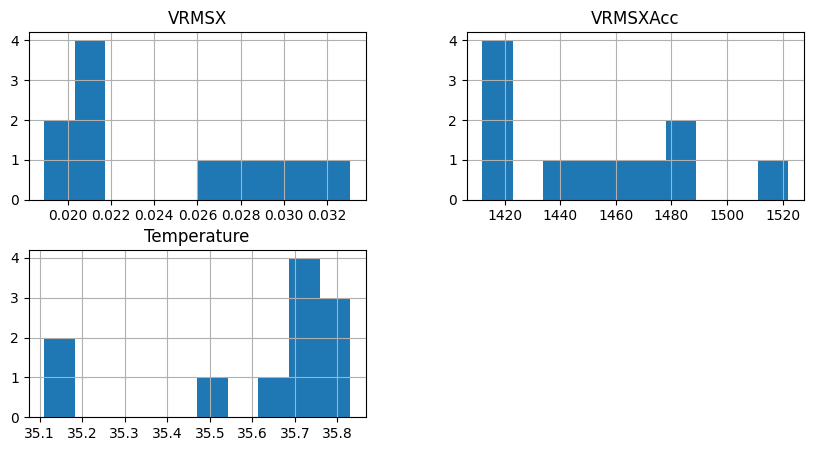

In [36]:
ask_question("特徴的なデータを探して")
